# Practical assignment

In this assignment you will analyse user comments from the website [reddit.com](http://www.reddit.com). Reddit users can post content (e.g., a website, a question, news), which can be up- or downvoted. Posts with many upvotes tend to appear in the top of the category or at the frontpage of Reddit. The website is quite popular and has over half a billion monthly visitors. At times, appearing on the frontpage of Reddit generates so much traffic to the posted website, that it actually crashes.

The community is organised in various subreddits, such as news, movies, music, et cetera. You will analyse user comments from the [politics subreddit](https://www.reddit.com/r/politics/). These user comments are either replies to the starting post, or replies to other users’ comments. The latter will be the basis for the communication network that you will construct here.

First let us get started with the data


## Data

If you have not done so already, download all data from https://storage.googleapis.com/css-files/reddit_discussion_network_2016_10.csv. This file is 377MB, it may take some time to download. If you have trouble working with this dataset on your computer, please try the alternative: https://storage.googleapis.com/css-files/reddit_discussion_network_2015_02.csv, which is only 46MB.

### Importing libraries

In [1]:
import random

# For network
import igraph as ig
import louvain

# For NLP
import nltk
import gensim

# For data handling
import pandas as pd

# For calculation
import numpy as np
import scipy

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/usr/local/lib/python2.7/dist-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


### Reading in data

First read in Reddit data.

In [2]:
data_path = '../../../data/reddit/'
file_name = 'reddit_discussion_network_2016_10.csv'
comments_df = pd.read_csv(data_path + file_name)

Which columns does this dataset have?

In [3]:
comments_df.columns

Index([u'comment', u'a_score', u'a_created_utc', u'a_retrieved_on',
       u'comment_id', u'comment_reply_to_id', u'author_from',
       u'author_reply_to'],
      dtype='object')

The first post:

In [4]:
comments_df.head(1)

,comment,a_score,a_created_utc,a_retrieved_on,comment_id,comment_reply_to_id,author_from,author_reply_to
0,You think these women were sitting out there m...,0,1476397749,1478583791,d8qwv4k,d8qwg9k,Schmingleberry,pm_me_your_cuck_pics


To help speed up the analysis, we already computed topic and sentiment values for each post. You can read the data as follows:

In [5]:
topic_sentiment_df = pd.read_csv(data_path + 'topic_sentiment_reddit.csv');

For each post, the topic distribution is saved in t_0 to t_14 (15 topics)

In [6]:
topic_sentiment_df.head(5)

,comment_id,author_from,pos,neg,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,t_9,t_10,t_11,t_12,t_13,t_14
0,d8qwv4k,Schmingleberry,0.0125,0.0,0.001667,0.150760,0.001667,0.001667,0.170236,0.001667,0.058648,0.001667,0.001667,0.146286,0.164797,0.001667,0.109014,0.061628,0.126965
1,d8p5x7o,socoamaretto,0.0000,0.0,0.016667,0.016667,0.016667,0.016667,0.016667,0.016667,0.016667,0.766667,0.016667,0.016667,0.016667,0.016667,0.016667,0.016667,0.016667
2,d9dpj9r,allisslothed,0.0000,0.0,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.533333,0.033333,0.033334
3,d8lh0lw,shaking_head,0.0250,0.0,0.002899,0.002899,0.046468,0.448935,0.131211,0.002899,0.002899,0.156079,0.002899,0.072449,0.002899,0.002899,0.118771,0.002899,0.002899
4,d8cu7q1,InFearn0,0.0000,0.0,0.338153,0.001515,0.001515,0.001515,0.060315,0.038145,0.001515,0.001515,0.032549,0.001515,0.112769,0.152212,0.060566,0.194684,0.001515


We then link this back to the original comments as follows:

In [7]:
comments_enriched_df = comments_df.merge(topic_sentiment_df)

We can now delete the `topic_sentiment_df` variable to save some memory.

In [8]:
del topic_sentiment_df

Let us calculate the interaction between all users.

In [9]:
grp_df = comments_enriched_df.groupby(['author_from', 'author_reply_to'])
interaction_df = grp_df.mean()
interaction_df['count'] = grp_df.size()

This only keeps the numerical columns (and throws away the text). We can now use this to build the network.

In [10]:
G = ig.Graph.TupleList(
        edges=interaction_df.reset_index().values,
        edge_attrs=interaction_df.columns,
        directed=True)

There are now four smaller subassignments which we will work on. You can choose any single one to work on. Hints for doing some of the analysis are provided after the description of the subassignments. Most of the techniques involved should already be explained during the lectures, but these hints provide some more explicit help.



# Topics and centrality

Users that are central tend to interact with lots of different (central) users. We could either expect that users become more central if they secure a position of authority in a single topic. In that case, everybody interacts with the user because he is authoritative in this subject. Alternatively, somebody can be more central because he is active in many different topics. Finally, somebody may simply be more central because he is active himself, and every comment is likely to get a reply.

Techniques necessary
- Topic detection
- Centrality

## Topic modelling

We now calculate the average values for each user as follows:

In [11]:
topic_sentiment_user_df = comments_enriched_df.groupby('author_from').mean()

In [12]:
topic_sentiment_user_df.head(5)

,a_score,a_created_utc,a_retrieved_on,pos,neg,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,t_9,t_10,t_11,t_12,t_13,t_14
author_from,,,,,,,,,,,,,,,,,,,,
--------Link--------,5.000000,1.475547e+09,1.478342e+09,0.000000,0.062500,0.262674,0.003509,0.003509,0.003509,0.003509,0.056574,0.069515,0.520009,0.003509,0.056140,0.003509,0.003509,0.003509,0.003509,0.003509
------________,-0.071429,1.475973e+09,1.478460e+09,0.017857,0.043675,0.017526,0.017526,0.039061,0.096752,0.074879,0.029013,0.190172,0.129516,0.017526,0.035383,0.050420,0.098166,0.151150,0.035383,0.017526
-----iMartijn-----,1.000000,1.477506e+09,1.478901e+09,0.002000,0.017867,0.018383,0.074263,0.005108,0.230240,0.116360,0.039299,0.017694,0.054546,0.005108,0.005108,0.247091,0.053790,0.102172,0.020444,0.010394
---CAISSON---,12.500000,1.477036e+09,1.478766e+09,0.000000,0.025000,0.009697,0.009697,0.109697,0.009697,0.009697,0.055152,0.009697,0.061478,0.009697,0.109697,0.367007,0.209697,0.009697,0.009697,0.009697
---DONTDIEWEMULTIPLY,6.370370,1.477943e+09,1.479020e+09,0.005842,0.007025,0.022242,0.154403,0.056291,0.104365,0.082621,0.054479,0.043127,0.086735,0.070458,0.050695,0.081356,0.032482,0.089906,0.057650,0.013191


You can the values for a particular user:

In [13]:
topic_sentiment_user_df.ix['---CAISSON---']

a_score           1.250000e+01
a_created_utc     1.477036e+09
a_retrieved_on    1.478766e+09
pos               0.000000e+00
neg               2.500000e-02
t_0               9.696986e-03
t_1               9.696972e-03
t_2               1.096970e-01
t_3               9.696971e-03
t_4               9.696970e-03
t_5               5.515152e-02
t_6               9.696970e-03
t_7               6.147798e-02
t_8               9.696970e-03
t_9               1.096970e-01
t_10              3.670069e-01
t_11              2.096969e-01
t_12              9.696995e-03
t_13              9.696974e-03
t_14              9.696970e-03
Name: ---CAISSON---, dtype: float64

You can easily grab only the topics

In [14]:
topic_sentiment_user_df.ix[:,'t_0':'t_14'].head(5)

,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,t_9,t_10,t_11,t_12,t_13,t_14
author_from,,,,,,,,,,,,,,,
--------Link--------,0.262674,0.003509,0.003509,0.003509,0.003509,0.056574,0.069515,0.520009,0.003509,0.056140,0.003509,0.003509,0.003509,0.003509,0.003509
------________,0.017526,0.017526,0.039061,0.096752,0.074879,0.029013,0.190172,0.129516,0.017526,0.035383,0.050420,0.098166,0.151150,0.035383,0.017526
-----iMartijn-----,0.018383,0.074263,0.005108,0.230240,0.116360,0.039299,0.017694,0.054546,0.005108,0.005108,0.247091,0.053790,0.102172,0.020444,0.010394
---CAISSON---,0.009697,0.009697,0.109697,0.009697,0.009697,0.055152,0.009697,0.061478,0.009697,0.109697,0.367007,0.209697,0.009697,0.009697,0.009697
---DONTDIEWEMULTIPLY,0.022242,0.154403,0.056291,0.104365,0.082621,0.054479,0.043127,0.086735,0.070458,0.050695,0.081356,0.032482,0.089906,0.057650,0.013191


You can also combine both the selection of users and of topics

In [15]:
topic_sentiment_user_df.ix['---CAISSON---','t_0':'t_14']

t_0     0.009697
t_1     0.009697
t_2     0.109697
t_3     0.009697
t_4     0.009697
t_5     0.055152
t_6     0.009697
t_7     0.061478
t_8     0.009697
t_9     0.109697
t_10    0.367007
t_11    0.209697
t_12    0.009697
t_13    0.009697
t_14    0.009697
Name: ---CAISSON---, dtype: float64

### Entropy

One way to calculate whether a user is posting mostly about one topic, or is the user is active in multiple topics is using **entropy** (https://en.wikipedia.org/wiki/Entropy_(information_theory))

This is an example where we have two topics. Because the probability of both topics is equal (0.5), the entropy is high.

In [16]:
scipy.stats.entropy([0.5, 0.5])

0.69314718055994529

Because in the following example all the probability is concentrated on one topic, the entropy is low (0).

In [17]:
scipy.stats.entropy([1, 0])

0.0

The overall entropy for all users can be calculated easily:

In [18]:
user_topic_entropy = topic_sentiment_user_df.ix[:,'t_0':'t_14'].apply(scipy.stats.entropy, axis=1)

## Centrality

There are various possible centralities. Betweenness in in too slow to calculate for this network, so we will only focus on eigenvector centrality, pagerank and (in- or out-)degree. You can try any one of them, just keep in mind when interpreting further results. You can get the centralities by running any one of the following:

In [19]:
G.es['weight'] = G.es['count']
G.vs['eigenvector_centrality'] = G.eigenvector_centrality(weights='weight')
G.vs['pagerank'] = G.pagerank(weights='weight')
G.vs['indegree'] = G.degree(mode=ig.IN)
G.vs['indegree_weighted'] = G.strength(mode=ig.IN, weights='weight')
G.vs['outdegree_weighted'] = G.strength(mode=ig.OUT, weights='weight')

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: RuntimeWarning: Weighted directed graph in eigenvector centrality at centrality.c:362
  from ipykernel import kernelapp as app


We can easily put all attributes from the graph in a pandas dataframe.

In [20]:
user_df = pd.DataFrame({attr: G.vs[attr] for attr in G.vertex_attributes()}).set_index('name')

Now let us also calculate the topic entropy for each user.

In [21]:
user_df['topic_entropy'] = user_topic_entropy

Note that there is not always information for all users, because not all users have written any comments themselves in this period. For example, BigDaddy2014 was replied 187 times, but he did not write a single comment himself during this period.

In [22]:
user_df.ix['BigDaddy2014',:]

eigenvector_centrality      0.004248
indegree                  186.000000
indegree_weighted         187.000000
outdegree_weighted          0.000000
pagerank                    0.000106
topic_entropy                    NaN
Name: BigDaddy2014, dtype: float64

For this particular assignment, it might be useful to filter users. If you include *all* users, then users who have only posted a few posts might have a topic distribution skewed towards a few topics, just because they haven't been active much. We can plot the results for users that have posted at least 50 comments.

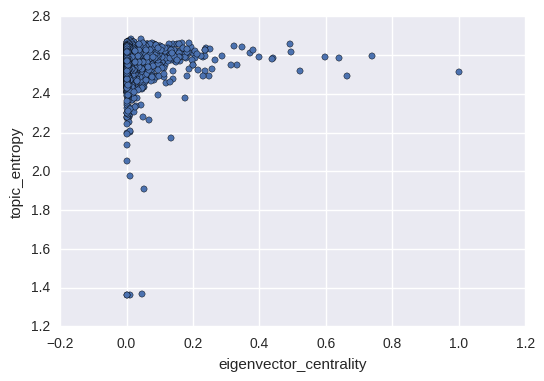

In [23]:
user_df[user_df['outdegree_weighted'] > 50].plot('eigenvector_centrality', 'topic_entropy', kind='scatter')

In [24]:
user_df[user_df['outdegree_weighted'] > 50].corr()

,eigenvector_centrality,indegree,indegree_weighted,outdegree_weighted,pagerank,topic_entropy
eigenvector_centrality,1.000000,0.698863,0.810727,0.678064,0.824508,0.070443
indegree,0.698863,1.000000,0.968885,0.781299,0.962392,0.170393
indegree_weighted,0.810727,0.968885,1.000000,0.837076,0.990396,0.142335
outdegree_weighted,0.678064,0.781299,0.837076,1.000000,0.792058,0.150243
pagerank,0.824508,0.962392,0.990396,0.792058,1.000000,0.141768
topic_entropy,0.070443,0.170393,0.142335,0.150243,0.141768,1.000000


** Todo: **
- Decide which users you will analyze
- Compute the centrality for each user
- Compute the topic distribution for each user. 
- Analyze whether there is a relation between the two measures.

# Sentiment and centrality 

In order to become central in the commenter network, sufficient people have to respond to your comment. Enticing others to respond is thus essential. This is more likely when comments are controversial: i.e. many people would disagree with the comment. What is controversial depends on in which environment a statement is made. At any rate, we could expect a controversial statement to be met with criticism. We should then expect that central people are more likely to be criticised, and that they attract relatively many negative comments.

Techniques necessary
- Sentiment analysis
- Centrality

## Sentiment analysis

In [25]:
from empath import Empath
lexicon = Empath()

Take a look at post number 340

In [26]:
print comments_df.ix[340, 'comment']

What nonsense. The country is called "The United States of America". States' rights are an integral part of the US and have been so ever since it's existence.

What exactly is supposed bad about states' rights? Are you one of those globalist "world government" loonies?


Analyze the comment using Empath

In [27]:
def tokenize(text):
    return list(gensim.utils.simple_preprocess(text))

In [28]:
lexicon.analyze(tokenize(comments_df.iloc[[340]]['comment'].values[0]), normalize=True)

{'achievement': 0.0,
 'affection': 0.0,
 'aggression': 0.0,
 'air_travel': 0.0,
 'alcohol': 0.0,
 'ancient': 0.0,
 'anger': 0.0,
 'animal': 0.0,
 'anonymity': 0.0,
 'anticipation': 0.0,
 'appearance': 0.0,
 'art': 0.0,
 'attractive': 0.0,
 'banking': 0.0,
 'beach': 0.0,
 'beauty': 0.0,
 'blue_collar_job': 0.0,
 'body': 0.0,
 'breaking': 0.0,
 'business': 0.0,
 'car': 0.0,
 'celebration': 0.0,
 'cheerfulness': 0.0,
 'childish': 0.0,
 'children': 0.0,
 'cleaning': 0.0,
 'clothing': 0.0,
 'cold': 0.0,
 'college': 0.0,
 'communication': 0.0,
 'competing': 0.0,
 'computer': 0.0,
 'confusion': 0.0,
 'contentment': 0.0,
 'cooking': 0.0,
 'crime': 0.0,
 'dance': 0.0,
 'death': 0.0,
 'deception': 0.0,
 'disappointment': 0.0,
 'disgust': 0.0,
 'dispute': 0.0,
 'divine': 0.0,
 'domestic_work': 0.0,
 'dominant_heirarchical': 0.022222222222222223,
 'dominant_personality': 0.0,
 'driving': 0.0,
 'eating': 0.0,
 'economics': 0.0,
 'emotional': 0.022222222222222223,
 'envy': 0.0,
 'exasperation': 0.0,

Again, we have precomputed the sentiment values (but if you have time: extend it and consider other features as well,
                                                like emotion)

Very similar to what we did before. Compute the mean for each author (but now we are looking at responses, so we look at 'author_reply_to')

In [29]:
G.vs['sentiment_strength_pos'] = G.strength(mode=ig.IN, weights='pos')
G.vs['sentiment_strength_neg'] = G.strength(mode=ig.IN, weights='neg')
G.vs['sentiment_strength'] = np.array(G.vs['sentiment_strength_pos']) - np.array(G.vs['sentiment_strength_neg'])

In [30]:
user_df = pd.DataFrame({attr: G.vs[attr] for attr in G.vertex_attributes()}).set_index('name')

In [31]:
user_df.corr()

,eigenvector_centrality,indegree,indegree_weighted,outdegree_weighted,pagerank,sentiment_strength,sentiment_strength_neg,sentiment_strength_pos
eigenvector_centrality,1.000000,0.744752,0.827584,0.724017,0.841163,-0.649749,0.709274,0.685767
indegree,0.744752,1.000000,0.979954,0.857785,0.972210,-0.873838,0.964279,0.945036
indegree_weighted,0.827584,0.979954,1.000000,0.891358,0.991086,-0.858091,0.942996,0.919446
outdegree_weighted,0.724017,0.857785,0.891358,1.000000,0.853220,-0.742593,0.820707,0.805849
pagerank,0.841163,0.972210,0.991086,0.853220,1.000000,-0.851680,0.935393,0.911355
sentiment_strength,-0.649749,-0.873838,-0.858091,-0.742593,-0.851680,1.000000,-0.953984,-0.753874
sentiment_strength_neg,0.709274,0.964279,0.942996,0.820707,0.935393,-0.953984,1.000000,0.916196
sentiment_strength_pos,0.685767,0.945036,0.919446,0.805849,0.911355,-0.753874,0.916196,1.000000


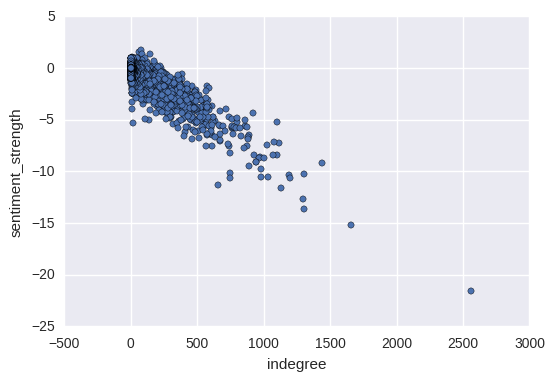

In [32]:
user_df.plot('indegree', 'sentiment_strength', kind='scatter')

# Communities of interest

Earlier today you learned that interaction is often homophilous: people with the same interest are more likely to be connected to each other. We will look into this question here on the basis of topics. Two question are central in this assignment: (1) are users that share topics more likely to be connected; and (2) does this create communities of interest.

Techniques necessary
- Topic modelling
- Assortativity
- Community detection

## Topic modelling

We already dispose of the average topic distribution for each user. It is easier to work with a single topic for each user.

In [33]:
user_topic = topic_sentiment_user_df.ix[:,'t_0':'t_14'].idxmax(axis=1)

Let us put this information from the dataframe in the graph. Because we only have topic information if somebody wrote a post, we will look at the subgraph of people having written at least some number of posts.

In [34]:
H = G.subgraph(G.vs.select(outdegree_weighted_ge=50))

In [35]:
H.vs['user_topic'] = user_topic.ix[H.vs['name']].str[2:].astype(int)

## Assortativity

The assortativity is easy to calculate:

In [37]:
H.assortativity_nominal(types='user_topic')

0.021013364403667398

## Community detection

The most difficult part of community detection is deciding what method is appropriate and sometimes what resolution is appropriate. Modularity is the most often used, and can be obtained as follows:

<div class="alert alert-warning">
Detecting communities may take some time.
</div>

In [ ]:
mod_partition = louvain.find_partition(H, 'Modularity', weight='count')

Now compare it to the partition based on the topics.

In [ ]:
topic_partition = ig.VertexClustering.FromAttribute(H, 'user_topic')
mod_partition.compare_to(topic_partition, 'nmi')

Alternatively, you can try out CPM, using various resolution values. Good resolution values are usually quite small, but this may depend on the weight. Around a resolution parameter of 1e-5 seems to be most interesting.

In [ ]:
CPM_partition = louvain.find_partition(H, 'CPM', weight='count', resolution_parameter=0.01)

In [ ]:
CPM_partition.sizes()[:10]

In [ ]:
CPM_partition.compare_to(topic_partition, 'nmi')

# Sentiment and language across communities

Following social balance theory, it is possible that the commenter network is polarized (not implausible given the divisive US politics). Simply looking at communication while disregarding the valence of the link (i.e. whether it was negative or positive) may distort our view of the integration of the network. We will use sentiment analysis of the comments to determine whether the links are in fact negative or positive. In this assignment two question are central: (1)  is sentiment different within sentiment different from sentiment between groups?; and (2) does the valence of links change the community structure?

Techniques necessary
- Sentiment analysis
- Community detection

## Sentiment analysis

First construct a single measure for whether a link is positive or negative.

In [ ]:
H.es['sentiment'] = np.array(H.es['pos']) - np.array(H.es['neg'])

Now look at whether it is more positive or negative between the communities we previously detected.

In [ ]:
edge_sentiment_group_df = pd.DataFrame({'sentiment': H.es['sentiment'],
                                        'crossing': CPM_partition.crossing()})
edge_sentiment_group_df.groupby('crossing').agg(['mean', 'std'])

## Community detection

Modularity is ordinarily not suited for community detection if the weights are negative. This can be corrected though, as is illustrated below.

In [ ]:
H_positive = H.subgraph_edges(H.es.select(sentiment_gt=0), delete_vertices=False)
H_negative = H.subgraph_edges(H.es.select(sentiment_lt=0), delete_vertices=False)

membership, quality = louvain.find_partition_multiplex([
louvain.Layer(graph=H_positive, method='Modularity', weight='sentiment', layer_weight=1.0),
louvain.Layer(graph=H_negative, method='Modularity', weight='sentiment', layer_weight=-1.0)])
balance_partition = ig.VertexClustering(H, membership)

Let us compare this partition to the previous parition we got using modularity.

In [ ]:
mod_partition.compare_to(balance_partition, 'nmi')